In [22]:
import pandas as pd
import os
import re
from html import unescape
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
from ftfy import fix_text
from unidecode import unidecode
import io


In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet

In [4]:
from wordcloud import WordCloud
import contractions
from tqdm.notebook import tqdm

In [5]:
# downloads (run once)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

# small plotting defaults
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10,5)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fahim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\fahim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fahim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fahim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\fahim\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\fahim\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
df = pd.read_csv("merged_singlelabel_textlabels.csv")

In [7]:
df.head(10)

,Text,emotion
0,"Now if he does off himself, everyone will thin...",neutral
1,WHY THE FUCK IS BAYLESS ISOING,anger
2,To make her feel threatened,fear
3,Dirty Southern Wankers,annoyance
4,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,surprise
5,Yes I heard abt the f bombs! That has to be wh...,gratitude
6,We need more boards and to create a bit more s...,desire
7,We need more boards and to create a bit more s...,optimism
8,Damn youtube and outrage drama is super lucrat...,admiration
9,It might be linked to the trust factor of your...,neutral


In [8]:
df = df.rename(columns={c:c.strip() for c in df.columns})
if 'Text' in df.columns:
    df = df.rename(columns={'Text':'text'})

In [9]:
print(df.shape)

(57431, 2)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57431 entries, 0 to 57430
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     57431 non-null  object
 1   emotion  57431 non-null  object
dtypes: object(2)
memory usage: 897.5+ KB


In [11]:
# missing values
print("Missing per column:")
print(df.isnull().sum())

# drop rows with null text or null emotion (or handle them differently)
df = df.dropna(subset=['text', 'emotion']).reset_index(drop=True)

Missing per column:
text       0
emotion    0
dtype: int64


In [12]:
vc = df['emotion'].value_counts()
print(vc)

emotion
neutral           16005
admiration         4634
approval           3290
gratitude          3014
annoyance          2790
amusement          2592
curiosity          2475
love               2324
disapproval        2289
optimism           1767
anger              1765
joy                1613
confusion          1521
sadness            1482
disappointment     1420
realization        1255
caring             1222
surprise           1201
excitement          956
disgust             916
desire              724
fear                674
remorse             601
embarrassment       340
nervousness         187
relief              164
pride               127
grief                83
Name: count, dtype: int64


In [23]:
def clean_text(s):
    if pd.isna(s):
        return s
    s = str(s)
    s = fix_text(s)       # fixes mojibake like â€™ → ’
    s = unidecode(s)      # optional: convert fancy chars to ascii (é → e, ’ → ')
    s = " ".join(s.split())  # normalize whitespace
    return s

# clean the "text" column in-place
df["text"] = df["text"].apply(clean_text)

# quick preview
print(df.head(10))

# save cleaned file
# df.to_csv("merged_singlelabel_textlabels_cleaned.csv", index=False, encoding="utf-8")
# print("Cleaned dataset saved as merged_singlelabel_textlabels_cleaned.csv")


                                                text     emotion  char_count  \
0  Now if he does off himself, everyone will thin...     neutral         112   
1                     WHY THE FUCK IS BAYLESS ISOING       anger          30   
2                        To make her feel threatened        fear          27   
3                             Dirty Southern Wankers   annoyance          22   
4  OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...    surprise          98   
5  Yes I heard abt the f bombs! That has to be wh...   gratitude         117   
6  We need more boards and to create a bit more s...      desire          82   
7  We need more boards and to create a bit more s...    optimism          82   
8  Damn youtube and outrage drama is super lucrat...  admiration          60   
9  It might be linked to the trust factor of your...     neutral          54   

   word_count  unique_word_count  avg_word_len  
0          20                 20      5.600000  
1           6        

In [24]:
# keep only text and emotion
df = df[["text", "emotion"]]

# lowercase the text column
df["text"] = df["text"].str.lower()

# quick preview
print(df.head(10))

# save cleaned dataset
# df.to_csv("merged_singlelabel_textlabels_cleaned.csv", index=False, encoding="utf-8")
# print("Cleaned dataset saved as merged_singlelabel_textlabels_cleaned.csv")


                                                text     emotion
0  now if he does off himself, everyone will thin...     neutral
1                     why the fuck is bayless isoing       anger
2                        to make her feel threatened        fear
3                             dirty southern wankers   annoyance
4  omg peyton isn't good enough to help us in the...    surprise
5  yes i heard abt the f bombs! that has to be wh...   gratitude
6  we need more boards and to create a bit more s...      desire
7  we need more boards and to create a bit more s...    optimism
8  damn youtube and outrage drama is super lucrat...  admiration
9  it might be linked to the trust factor of your...     neutral


In [25]:
df.to_csv("goemo_dataset.csv", index=False, encoding="utf-8")

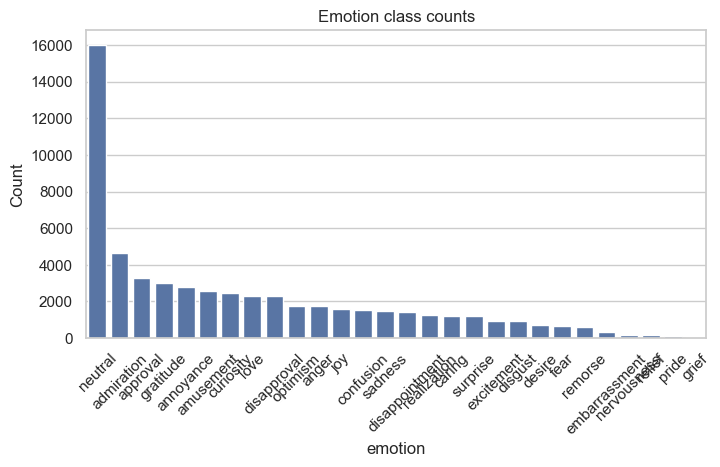

In [26]:
# bar plot
plt.figure(figsize=(8,4))
sns.barplot(x=vc.index, y=vc.values)
plt.title('Emotion class counts')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

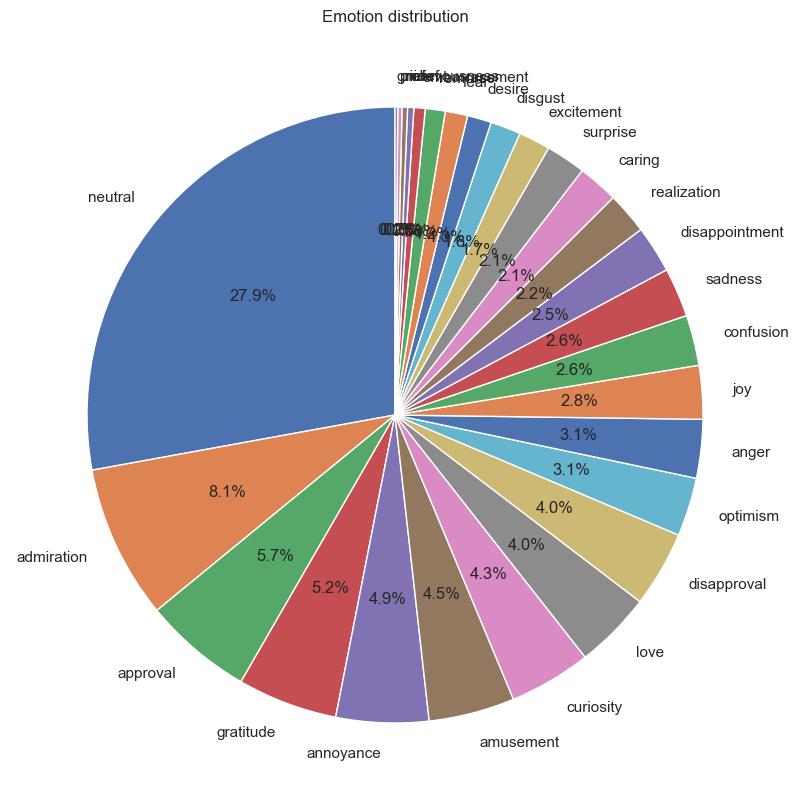

In [27]:
# pie chart
plt.figure(figsize=(10,10))
plt.pie(vc.values, labels=vc.index, autopct='%1.1f%%', startangle=90)
plt.title('Emotion distribution')
plt.show()

In [28]:
for emo, group in df.groupby('emotion'):
    print(f"\n--- {emo} ---")
    display(group['text'].sample(3, random_state=1) if len(group)>=3 else group['text'].head(3))



--- admiration ---


13125    wow! congrats! i am really proud of you. hopef...
11126                                    that's beautiful.
33894                         i make my cows super stronk.
Name: text, dtype: object


--- amusement ---


21373    maybe? but his foot goes waaaay up lol. maybe ...
51555                i always fall for this joke on here..
21857    time flies so fast when you're 18. i didnt exp...
Name: text, dtype: object


--- anger ---


21632    what she is doing is child abuse, plain and si...
43600    you can't demand historical accuracy 'at all' ...
22302    the fuck? come from nothing, now something doe...
Name: text, dtype: object


--- annoyance ---


5153     > this isn't where i parked my car seriously i...
29653      i dont think you guys understand it at all tbh.
34934    argh. the most stupid and needless abuse of po...
Name: text, dtype: object


--- approval ---


5669     although these are seemingly overpriced, yes, ...
56832          i get ya man. it happens to the best of us.
52831    yeah i agree w you, just annoying that the lim...
Name: text, dtype: object


--- caring ---


49954    be strong. i've felt the same way before in my...
24761    in such a situation, i would save the mother. ...
6478     just be there for him in the best way you can....
Name: text, dtype: object


--- confusion ---


36281    okay, so that doesn't really answer my questio...
14590    i don't really understand what you mean haha c...
42859    i laughed. but i'm really not sure if i should...
Name: text, dtype: object


--- curiosity ---


53749                                        why i wonder?
52546    heya, how would u rate this story? esp compare...
16321    so it's like the first game then? the only thi...
Name: text, dtype: object


--- desire ---


48802                      we're gonna need a bigger boat.
51260    do you have the link to that ? i would love to...
20364                               i want a pizza flair!!
Name: text, dtype: object


--- disappointment ---


6336     i'm missing the "funny" part. this is just som...
1210                                  he's soft. no heart.
21427    i stopped watching [name] the moment vie when ...
Name: text, dtype: object


--- disapproval ---


44848    i was already taking a break from basketball t...
29376                            not delusional at all imo
17206    there is nothing adorable about that terrifyin...
Name: text, dtype: object


--- disgust ---


17152    oh yes! i did not know pizza could possibly ev...
44086    literally all of them have said and done much ...
8775                                   oh no, her eyebrows
Name: text, dtype: object


--- embarrassment ---


16959    please tell me you were buying something extre...
19880    also not true. germany had pervasive antisemet...
2900     ugh foot rubs. i feel embarrassed thinking abo...
Name: text, dtype: object


--- excitement ---


14126    sounds like a fun game. our home game around h...
57066    germany is the first country in europe i've be...
26868    the excitement when they all first come in alw...
Name: text, dtype: object


--- fear ---


33824    that live snail got me freaked
51932                   this is creepy.
31608            it's so fucking creepy
Name: text, dtype: object


--- gratitude ---


20681       exactly, you never know. good luck for monday!
34656    thank you for reminding me about how much i lo...
32618                      thank you for the kind words :)
Name: text, dtype: object


--- grief ---


5338     he's eating cheese and watching football in th...
49382                   i mourn for you anti-intellectuals
31846                 oh, that's horrible. my condolences.
Name: text, dtype: object


--- joy ---


44931    glad you had fun!! did you all, ya'know? did y...
9423     ya! it was a bangin' movie! a super fun ride w...
56267    is...is this a hitman themed fe shitpost?...i ...
Name: text, dtype: object


--- love ---


14451    i love [name]. but i'm not sure there is a sin...
31015    np just passing it forward from another commen...
1206                     wow this is amazing. love this!!!
Name: text, dtype: object


--- nervousness ---


4449     i'm feeling the same about the nets and hornet...
52891    really worried about nisa translating it, but ...
38139                                  this sub is so edgy
Name: text, dtype: object


--- neutral ---


10651    you bet, sweetie ;) but i date girls so don't ...
42543    no. let them earn it. and they are and will co...
32995                   that lady is experiencing pure joy
Name: text, dtype: object


--- optimism ---


41812    will you ask her to pray to her god and ask hi...
43462    i wouldn't even call this a cb, she wasn't off...
20875                           i hope g2 such a great org
Name: text, dtype: object


--- pride ---


56079    we have reached the stage where below 2 millio...
22732                                               i did.
36601    even when drinking, i would remember that d is...
Name: text, dtype: object


--- realization ---


19059    and this is why i, having been baptized [relig...
41717    all the best things happen after midnight. all...
17573    i just had to tell at her parents and pass on ...
Name: text, dtype: object


--- relief ---


16255    so glad you are safe. it looks like icy condit...
17408    i also think license should be spelled liscenc...
55322    i have little to no anxiety and it really help...
Name: text, dtype: object


--- remorse ---


41688    well he hasn't dont anything good ever. so sor...
37461                sorry but imma hit you with a fat (x)
46812    oh sorry. instead of "willfully stupid " i mea...
Name: text, dtype: object


--- sadness ---


7527     they're all the same, all the ratemes are a tr...
14548    tell him congrats. and that he srsly needs to ...
3410     i remember that. it was a crushing experience ...
Name: text, dtype: object


--- surprise ---


29915            i'm amazed people read buzzfeed articles.
28879    suddenly, the **average** block confirmation b...
12540    breaking news: man write op-ed about what's ba...
Name: text, dtype: object

In [29]:
# features
df['char_count'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().apply(len)
df['unique_word_count'] = df['text'].str.split().apply(lambda x: len(set(x)))
df['avg_word_len'] = df['char_count'] / (df['word_count']+1e-9)

In [30]:
# max word count in dataset
max_word_count = df['word_count'].max()
min_word_count = df['word_count'].min()
avg_word_count = df['word_count'].mean()

print("Max word count in a text:", max_word_count)
print("Min word count in a text:", min_word_count)
print("Average word count per text:", round(avg_word_count, 2))

Max word count in a text: 68
Min word count in a text: 1
Average word count per text: 13.0


In [31]:
# show the text(s) with max word count
longest_texts = df.loc[df['word_count'] == max_word_count, ['text','word_count','emotion']]
print("\nTexts with maximum word length:")
display(longest_texts)


Texts with maximum word length:


,text,word_count,emotion
25476,for your kindness to mobile users i give a pla...,68,neutral


In [32]:
# show the text(s) with min word count
longest_texts = df.loc[df['word_count'] == min_word_count, ['text','word_count','emotion']]
print("\nTexts with minimum word length:")
display(longest_texts)


Texts with minimum word length:


,text,word_count,emotion
235,[name],1,disgust
631,wow.,1,surprise
835,wow!!!,1,excitement
836,wow!!!,1,surprise
965,source???!,1,neutral
...,...,...,...
55351,this!!,1,excitement
56265,thanks!!,1,gratitude
56679,hysterical!!!!,1,neutral
56931,ugh...terrible.,1,annoyance


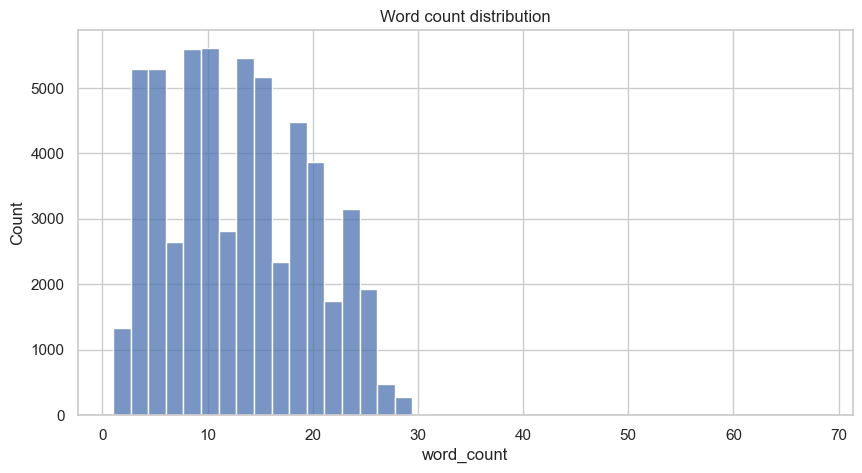

In [33]:
# distribution plots
plt.figure()
sns.histplot(df['word_count'], bins=40, kde=False)
plt.title('Word count distribution')
plt.show()

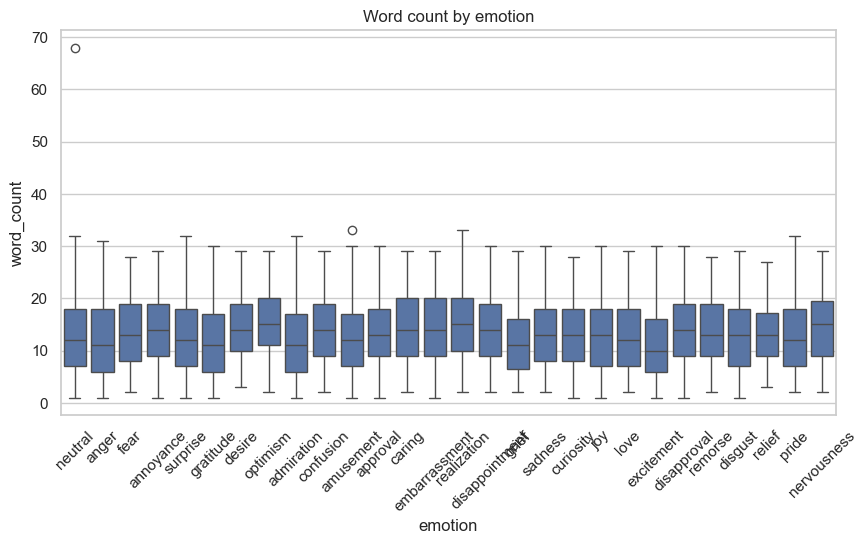

In [34]:
plt.figure()
sns.boxplot(x='emotion', y='word_count', data=df)
plt.title('Word count by emotion')
plt.xticks(rotation=45)
plt.show()

In [35]:
import re
from html import unescape
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize

lemmatizer = WordNetLemmatizer()
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    # stopwords resource missing — use a small built-in list as fallback
    stop_words = set([
        'a','an','the','and','or','if','in','on','of','to','is','it','this','that',
        'i','you','he','she','we','they','me','him','her','them'
    ])
    print("Using fallback stopword list (NLTK stopwords missing).")

from nltk.corpus import wordnet
def nltk_pos_to_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess_text_resilient(text, remove_stopwords=True, lemmatize=True):
    """Robust preprocess: tries full NLTK pipeline; on LookupError falls back to simpler tokenization."""
    if pd.isna(text):
        return ""
    text = str(text)
    text = unescape(text)
    try:
        text = contractions.fix(text)
    except Exception:
        pass
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)

    # Try full NLTK tokenization + pos + lemmatization
    try:
        tokens = word_tokenize(text)
        if remove_stopwords:
            tokens = [t for t in tokens if t not in stop_words]
        if lemmatize:
            try:
                pos_tags = pos_tag(tokens)
                tokens = [lemmatizer.lemmatize(tok, pos=nltk_pos_to_wordnet_pos(tag)) for tok, tag in pos_tags]
            except LookupError:
                # pos tagger missing — lemmatize without POS
                tokens = [lemmatizer.lemmatize(tok) for tok in tokens]
    except LookupError:
        # fallback: simple split-based tokenization
        tokens = text.split()
        if remove_stopwords:
            tokens = [t for t in tokens if t not in stop_words]
        # no lemmatization in this fallback
    # remove short tokens
    tokens = [t for t in tokens if len(t) > 1]
    return " ".join(tokens)


In [36]:
# register tqdm; fallback to plain apply if registration fails
try:
    tqdm.pandas()
    use_tqdm = True
except Exception as e:
    print("tqdm.pandas() registration failed:", e)
    use_tqdm = False

import time
start = time.time()
if use_tqdm:
    df['clean_text'] = df['text'].progress_apply(preprocess_text_resilient)
else:
    df['clean_text'] = df['text'].apply(preprocess_text_resilient)
end = time.time()
print(f"Preprocessing done in {end-start:.1f}s. Processed {len(df)} rows.")
display(df[['text','clean_text']].head(8))


  0%|          | 0/57431 [00:00<?, ?it/s]

Preprocessing done in 55.9s. Processed 57431 rows.


,text,clean_text
0,"now if he does off himself, everyone will thin...",everyone think he laugh screw people instead a...
1,why the fuck is bayless isoing,fuck bayless isoing
2,to make her feel threatened,make feel threaten
3,dirty southern wankers,dirty southern wanker
4,omg peyton isn't good enough to help us in the...,omg peyton good enough help playoffs dumbass b...
5,yes i heard abt the f bombs! that has to be wh...,yes hear bomb thanks reply hubby anxiously wait
6,we need more boards and to create a bit more s...,need board create bit space name good
7,we need more boards and to create a bit more s...,need board create bit space name good


In [37]:
# 1) basic stats: max / min / mean for words & chars
df['char_count'] = df['text'].astype(str).str.len()
df['word_count'] = df['text'].astype(str).str.split().apply(len)   # original text length
df['clean_word_count'] = df['clean_text'].astype(str).str.split().apply(len)  # after cleaning

print("MAX words (original):", df['word_count'].max())
print("MAX words (cleaned):", df['clean_word_count'].max())
print("MIN words (original):", df['word_count'].min())
print("AVG words (original):", round(df['word_count'].mean(), 2))
print("MAX chars:", df['char_count'].max())
print("AVG chars:", round(df['char_count'].mean(), 2))


MAX words (original): 68
MAX words (cleaned): 196
MIN words (original): 1
AVG words (original): 13.0
MAX chars: 1650
AVG chars: 69.21


In [39]:
df.head(5)

,text,emotion,char_count,word_count,unique_word_count,avg_word_len,clean_text,clean_word_count
0,"now if he does off himself, everyone will thin...",neutral,112,20,20,5.600000,everyone think he laugh screw people instead a...,9
1,why the fuck is bayless isoing,anger,30,6,6,5.000000,fuck bayless isoing,3
2,to make her feel threatened,fear,27,5,5,5.400000,make feel threaten,3
3,dirty southern wankers,annoyance,22,3,3,7.333333,dirty southern wanker,3
4,omg peyton isn't good enough to help us in the...,surprise,98,17,17,5.764706,omg peyton good enough help playoffs dumbass b...,12


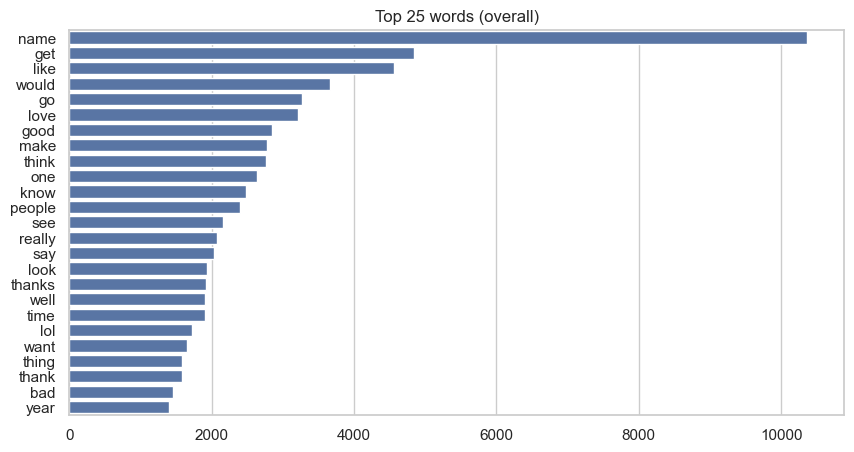

In [41]:
# helper to plot top n words
def plot_top_n_words(corpus, n=20, title='Top words'):
    vec = CountVectorizer(ngram_range=(1,1)).fit(corpus)
    bag = vec.transform(corpus)
    sum_words = bag.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    words = [w for w,c in words_freq]
    counts = [c for w,c in words_freq]
    sns.barplot(x=counts, y=words)
    plt.title(title)
    plt.show()

plot_top_n_words(df['clean_text'], n=25, title='Top 25 words (overall)')

In [42]:
# top bigrams
def top_ngrams(corpus, n=20, ngram_range=(2,2)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag = vec.transform(corpus)
    sum_words = bag.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    return words_freq

bigrams = top_ngrams(df['clean_text'], n=20, ngram_range=(2,2))
pd.DataFrame(bigrams, columns=['bigram','count']).head(20)

,bigram,count
0,look like,492
1,feel like,328
2,good luck,299
3,sound like,285
4,year old,179
5,year ago,146
6,make sense,145
7,new year,114
8,make feel,111
9,thanks share,102


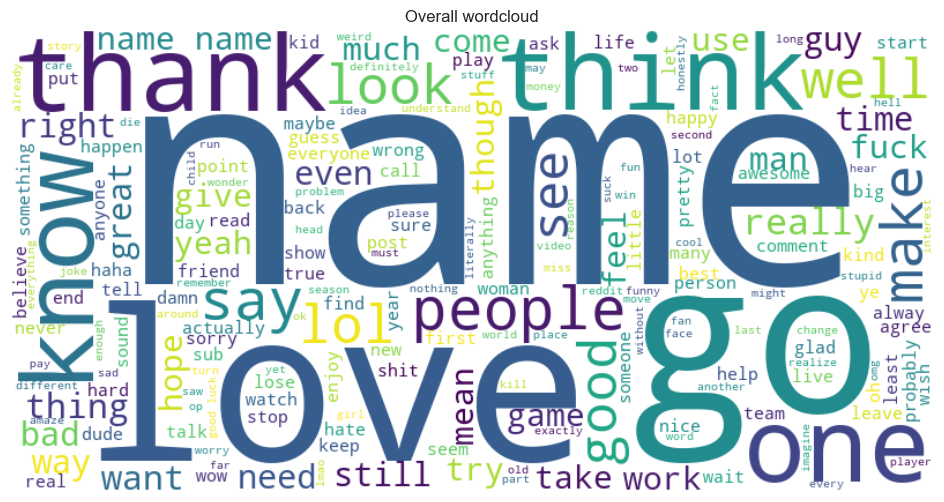

In [43]:
# overall
all_text = " ".join(df['clean_text'].astype(str))
wc = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Overall wordcloud")
plt.show()

C:\Users\fahim\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


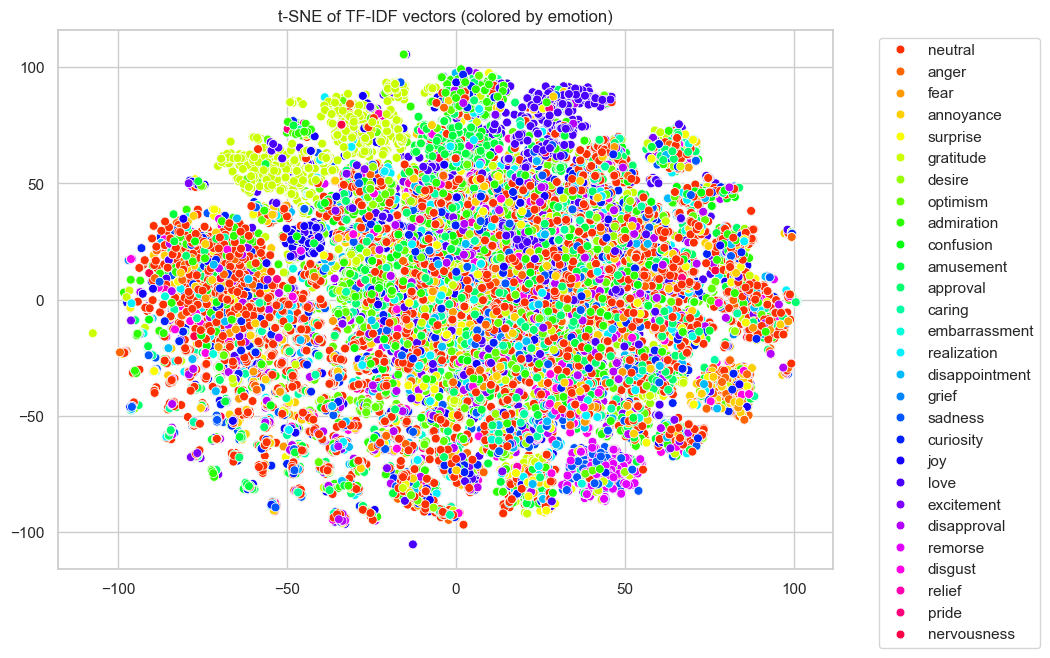

In [44]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(df['clean_text'].astype(str))

# reduce dimensionality (SVD then TSNE for speed)
svd = TruncatedSVD(n_components=50, random_state=42)
X_svd = svd.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42, perplexity=40, n_iter=800, init='pca')
X_tsne = tsne.fit_transform(X_svd)

plt.figure(figsize=(10,7))
palette = sns.color_palette('hsv', n_colors=len(df['emotion'].unique()))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df['emotion'], legend='full', palette=palette, s=40)
plt.title('t-SNE of TF-IDF vectors (colored by emotion)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [45]:
# show top 10 words per top 6 emotions
from sklearn.feature_extraction.text import CountVectorizer
topk = 10
for emo in top_emotions:
    corpus = df.loc[df['emotion']==emo, 'clean_text'].astype(str)
    vec = CountVectorizer(stop_words='english', max_features=2000).fit(corpus)
    bag = vec.transform(corpus)
    sum_words = bag.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:topk]
    print(f"\nTop words for {emo}:")
    print(words_freq)


NameError: name 'top_emotions' is not defined

In [46]:
# correlation between word_count and classes (mean per class)
display(df.groupby('emotion')['word_count','char_count','unique_word_count'].mean().sort_values('word_count', ascending=False))

# check class balance (again) and option to under/oversample before model training
print(df['emotion'].value_counts())


ValueError: Cannot subset columns with a tuple with more than one element. Use a list instead.

In [47]:
# ensure the feature columns exist
if 'unique_word_count' not in df.columns:
    df['unique_word_count'] = df['text'].astype(str).str.split().apply(lambda toks: len(set(toks)))

# groupby and compute means (use a list to select columns)
grouped = df.groupby('emotion')[['word_count', 'char_count', 'unique_word_count']].mean()

# sort by mean word_count descending
grouped_sorted = grouped.sort_values(by='word_count', ascending=False)
display(grouped_sorted)

# check class balance
print("Class counts:\n", df['emotion'].value_counts())


,word_count,char_count,unique_word_count
emotion,,,
optimism,15.399547,79.884550,14.574420
realization,15.176892,80.481275,14.231873
desire,14.613260,73.190608,13.691989
disappointment,14.445070,77.040141,13.714085
confusion,14.394477,75.887574,13.619329
embarrassment,14.379412,77.576471,13.517647
nervousness,14.288770,75.914439,13.508021
caring,14.066285,73.896890,13.281506
disapproval,13.961118,75.666667,13.217125


Class counts:
 emotion
neutral           16005
admiration         4634
approval           3290
gratitude          3014
annoyance          2790
amusement          2592
curiosity          2475
love               2324
disapproval        2289
optimism           1767
anger              1765
joy                1613
confusion          1521
sadness            1482
disappointment     1420
realization        1255
caring             1222
surprise           1201
excitement          956
disgust             916
desire              724
fear                674
remorse             601
embarrassment       340
nervousness         187
relief              164
pride               127
grief                83
Name: count, dtype: int64


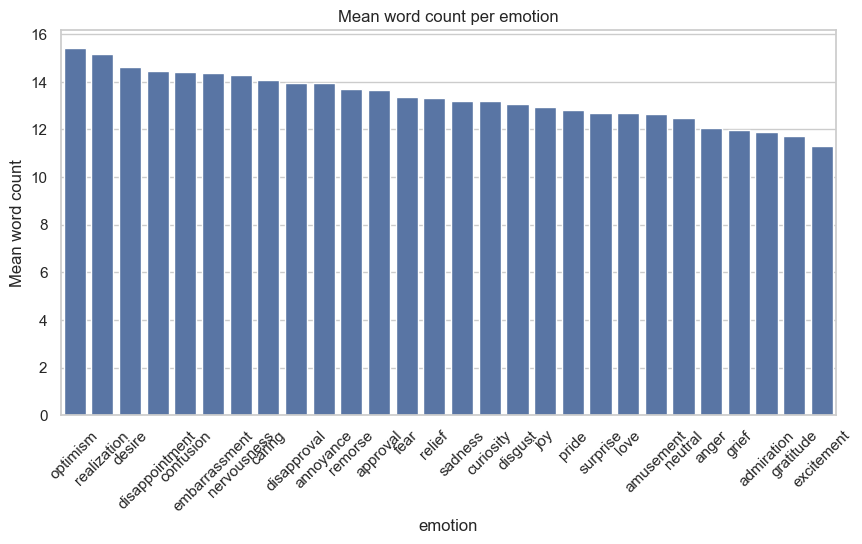

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(x=grouped_sorted.index, y=grouped_sorted['word_count'].values)
plt.xticks(rotation=45)
plt.ylabel('Mean word count')
plt.title('Mean word count per emotion')
plt.show()

In [49]:
df.head(5)

,text,emotion,char_count,word_count,unique_word_count,avg_word_len,clean_text,clean_word_count
0,"now if he does off himself, everyone will thin...",neutral,112,20,20,5.600000,everyone think he laugh screw people instead a...,9
1,why the fuck is bayless isoing,anger,30,6,6,5.000000,fuck bayless isoing,3
2,to make her feel threatened,fear,27,5,5,5.400000,make feel threaten,3
3,dirty southern wankers,annoyance,22,3,3,7.333333,dirty southern wanker,3
4,omg peyton isn't good enough to help us in the...,surprise,98,17,17,5.764706,omg peyton good enough help playoffs dumbass b...,12


In [50]:
df.to_csv("abc.csv", index=False, encoding="utf-8")